<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/BigDataProject/blob/main/ArimaModels_Alex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quandl

Reading In Data


In [121]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests as grangercausalitytests
import quandl
import requests
from bs4 import BeautifulSoup
import numpy as np





# reading in macro datacsv
df1 = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Macro%20Data.csv")

df1['DATE'] = df1['DATE'].apply(lambda x: datetime.datetime.strptime(str(x), "%m/%d/%Y"))
#df1.drop(columns=["Unnamed: 7", "% Change (M/M)", "%Change (Q/Q)", "% Change (Y/Y)", "% Change Q/Q", "DATE"], inplace =True )
print(df1.info())
print(df1.head())


#df1 = df1.set_index(['DATE'], drop=True)
# pmi data from quandl
quandl.ApiConfig.api_key = "FxsNx9PisEsskkErUy4k"
df2 = quandl.get("ISM/MAN_PMI")

print(df2.info())
print(df2.head())
df2.to_csv('C:')

# treasury data
# webscrape of the Treasury's web page and creating a dataframe of the daily treasury history

url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll'

r = requests.get(url)
html = r.text
soup = BeautifulSoup(html)
table = soup.find('table', {"class": "t-chart"})
rows = table.find_all('tr')
data = []
for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

df3 = pd.DataFrame(data, columns=['Date', 'One_Mo', 'Two_Mo', 'Three_Mo', 'Six_Mo', 'One_Yr', 'Two_Yr', 'Three_Yr', 'Five_Yr', 'Seven_Yr', 'Ten_Yr', 'Twenty_Yr', 'Thirty_Yr'])

df3.replace(to_replace='N/A', value=0, inplace=True)
df3 = df3.astype({'One_Mo':'float64', 'Two_Mo':'float64', 'Three_Mo':'float64', 'Six_Mo':'float64', 'One_Yr':'float64', 'Two_Yr':'float64', 'Three_Yr':'float64', 'Five_Yr':'float64', 'Seven_Yr':'float64', 'Ten_Yr':'float64', 'Twenty_Yr':'float64', 'Thirty_Yr':'float64'})
df3['Date'] = pd.to_datetime(df3['Date'], format="%m/%d/%y")
print(df3.info())
print(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   DATE                                  894 non-null    datetime64[ns]
 1   CPIAUCSL                              894 non-null    float64       
 2   CPI % Change (M/M)                    893 non-null    float64       
 3   CPI %Change (Q/Q)                     891 non-null    float64       
 4   CPI % Change (Y/Y)                    882 non-null    float64       
 5   Nominal GDP                           894 non-null    float64       
 6   Nominal% Change Q/Q                   891 non-null    float64       
 7   Total Business inventories            354 non-null    float64       
 8   Initial Claims (Seasonally Adjusted)  654 non-null    float64       
 9   DXY Open                              438 non-null    float64       
 10  DX

Merging everything into 1 dataframe

In [154]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
df2.index.normalize

# merging pmi data to econ data
dfmain = pd.merge(df1, df2, how='left', left_on='DATE', right_on='Date')

# transformations on treasury data
df3['TwoTenSpread'] = df3['Ten_Yr'] - df3['Two_Yr']

# monthly returns from daily returns
df3['TwoTenSpreadPctChange'] = df3['TwoTenSpread'].pct_change()
df3['DateMonth'] = df3['Date'].dt.to_period("M")
df4 = df3[['DateMonth','TwoTenSpread']]
df4['TwoTenMonthlyVariance'] = df4.groupby(['DateMonth']).transform(np.std)
df4 = df4[['DateMonth', 'TwoTenMonthlyVariance']]
df4 = df4.drop_duplicates()
df4.reset_index(inplace=True,drop='index')
df4['DateMonth'] = df4['DateMonth'].astype(str)
df4['Date'] = pd.to_datetime(df4['DateMonth'])
df4.drop(columns=['DateMonth'], inplace=True)
df4.set_index('Date', drop=True, inplace=True)

# merging 2/10 to main dataframe
dfmain = pd.merge(dfmain, df4, how='left', left_on='DATE', right_index=True)
dfmain.set_index('DATE', inplace=True)

# column transformations to attempt to get stationary values
dfmain['CpiAnnualizedPct'] = ((dfmain['CPIAUCSL']/dfmain['CPIAUCSL'].shift(1))**12-1)*100 
dfmain['GdpAnnualizedPct'] = ((dfmain['Nominal GDP']/dfmain['Nominal GDP'].shift(1))**12-1)*100 
dfmain['BopPct'] = dfmain['Balance of Payments Value'].pct_change()
dfmain['InventoriesPct'] = dfmain['Total Business inventories'].pct_change()
dfmain['WtiPct'] = dfmain['WTI SPOT Price']

# dropping columns
dfmain = dfmain.drop(columns=['CPIAUCSL', 'CPI % Change (M/M)','CPI %Change (Q/Q)'
                      ,'CPI % Change (Y/Y)', 'Nominal GDP', 'Nominal% Change Q/Q'
                      ,'DXY Open', 'DXY Low', 'DXY High', 'Balance of Payments Value'
                      ,'WTI SPOT Price', 'Vix Open', 'Vix Close', 'Total Business inventories'])
print(dfmain.columns)
print(dfmain.info())

Index(['Initial Claims (Seasonally Adjusted)', 'DXY Close', 'Vix High',
       'Vix Low', 'PMI', 'TwoTenMonthlyVariance', 'CpiAnnualizedPct',
       'GdpAnnualizedPct', 'BopPct', 'InventoriesPct', 'WtiPct'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 894 entries, 1947-01-01 to 2021-06-01
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Initial Claims (Seasonally Adjusted)  654 non-null    float64
 1   DXY Close                             438 non-null    float64
 2   Vix High                              438 non-null    float64
 3   Vix Low                               438 non-null    float64
 4   PMI                                   882 non-null    float64
 5   TwoTenMonthlyVariance                 378 non-null    float64
 6   CpiAnnualizedPct                      893 non-null    float64
 7   GdpAnnualizedPct                      

Function to check to see if each series is stationary and to plot series and autocorrlation 

In [155]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

def ADFtest(dataframe, column):
  # takes in dataframe, and column name. subsets the dataframe,
  # checks for stationarity and plots series and autocorrelation
  df = dataframe[column]
  df = df[df.notna()]
  print("ADF TEST:" + column)
  df = df.replace([np.inf, -np.inf], np.nan).dropna()
  result1 = adfuller(df)
  print('ADF Statistic: %f' % result1[0])
  print('p-value: %f' % result1[1])
  if result1[1] > 0.05:
    return print("This Series is not stable")
  else:
    fig, axis = plt.subplots(2, figsize = (9,9))
    axis[0].set_xlabel("Date")
    axis[0].set_ylabel(column)
    axis[0].set_title(column + " Over Time")
    df.plot(ax=axis[0], style='k-')
    plot_acf(df, ax=axis[1])
    axis[0].set_title(column + "Autocorrelation Plot")
    plt.show()

In [207]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
# arima forecasting function

def ARIMA_modeling_and_forecast(df, column):
  # Arima Model testing, fitting, and forecast 
  # function assumes a stationary time series is introduced

  # test train split 66% through
  splitIndex =  round(len(df)*0.8)
  traindf = df.iloc[0:round(len(df)*0.8)]
  traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
  testdf = df.iloc[round(len(df)*0.8)+1:]
  testdf = testdf.replace([np.inf, -np.inf], np.nan).dropna()
  parameters = []
  for pindex in range(3):
    for qindex in range(3):
      p = pindex + 1 
      q = qindex + 1
      try:
        Model1 = ARIMA(traindf, order = (p,1,q)).fit()
        param = {'AR': p, 'MA': q, 'AIC':Model1.aic} 
        parameters.append(param)
      except ValueError:
        pass  
        return print("Dont work")

      #print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)

    # finding best parameters
  modelparams = pd.DataFrame(parameters)
  bestparams = modelparams[modelparams['AIC'] == modelparams['AIC'].min()]
  # fitting best model
  Fitted_model = ARIMA(traindf
                       ,order = (int(bestparams.iloc[0]['AR'])
                       ,1
                       ,int(bestparams.iloc[0]['MA']))).fit()
  print(bestparams)
  # forecasting
  predictions = list()

  # walk-forward validation
  predictions = Fitted_model.forecast(steps=len(testdf))[0]
  predictionsdf = pd.DataFrame({'Date':testdf.index,'Predictions': predictions })
  predictionsdf.set_index('Date', inplace=True)

  # evaluate forecasts
  rmse = sqrt(mean_squared_error(testdf, predictions))


  returnval = round((predictionsdf.iloc[-1,0] - predictionsdf.iloc[0,0])/predictionsdf.iloc[0,0]*100,2)

    # plot forecasts against actual outcomes
  plt.title('Forecast for '+ column)
  plt.plot(testdf)
  plt.plot(predictionsdf, color='red')
  plt.show()

Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
Dont work
   AR  MA          AIC
6   3   1  2177.956832


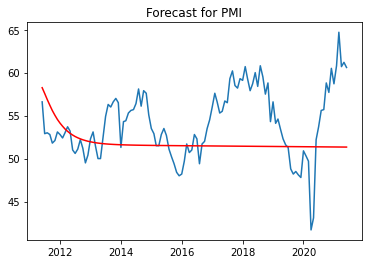

Dont work
Dont work
Dont work
   AR  MA         AIC
8   3   3 -864.956808


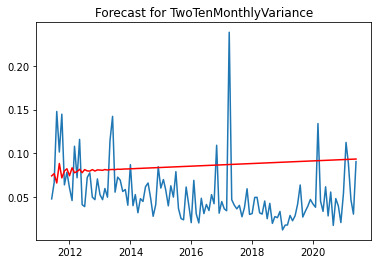

   AR  MA         AIC
1   1   2  496.592587


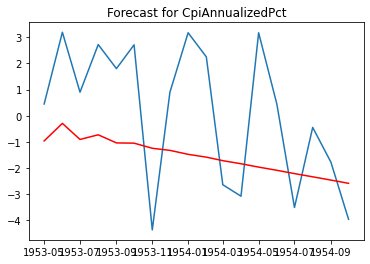

   AR  MA         AIC
5   2   3  332.510317


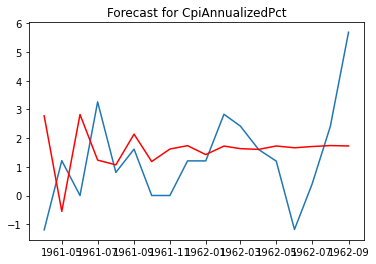

Dont work
   AR  MA          AIC
0   1   1  2503.093358


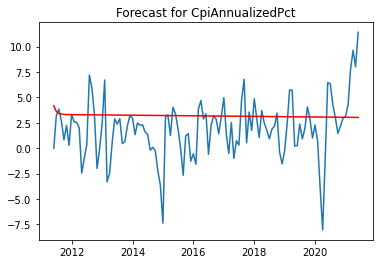

   AR  MA         AIC
6   3   1  619.283672


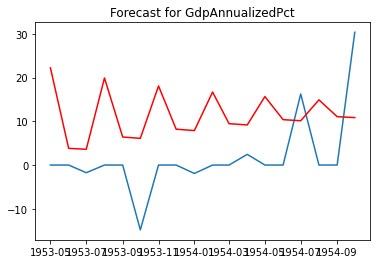

   AR  MA         AIC
6   3   1  566.856509


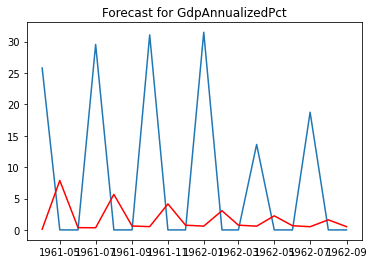

LinAlgError: ignored

In [208]:
for column in list(dfmain):
  testingdf = dfmain[column]
  testingdf1 = testingdf.iloc[0:round(len(df)*0.25)]
  testingdf2 = testingdf.iloc[round(len(df)*0.25)+1:round(len(df)*0.5)]
  testingdf3 = testingdf.iloc[round(len(df)*0.5)+1:round(len(df)*0.75)]
  testingdf4 = testingdf.iloc[round(len(df)*0.75)+1:]
  ARIMA_modeling_and_forecast(testingdf1, column)
  ARIMA_modeling_and_forecast(testingdf2, column)
  ARIMA_modeling_and_forecast(testingdf3, column)
  ARIMA_modeling_and_forecast(testingdf4, column)




ADF TEST:Initial Claims (Seasonally Adjusted)
ADF Statistic: -6.194579
p-value: 0.000000


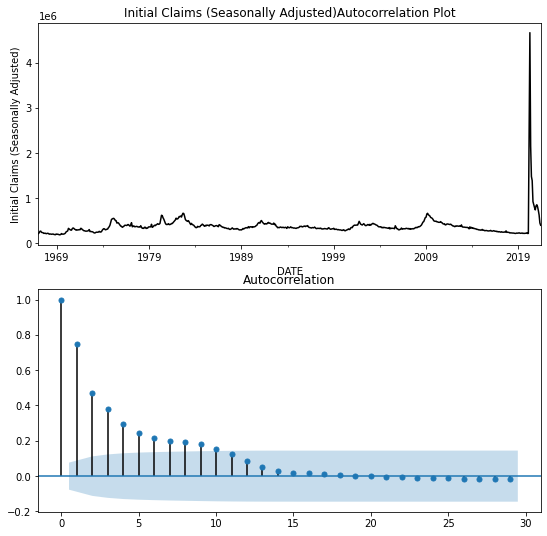

ADF TEST:DXY Close
ADF Statistic: -5.762013
p-value: 0.000001


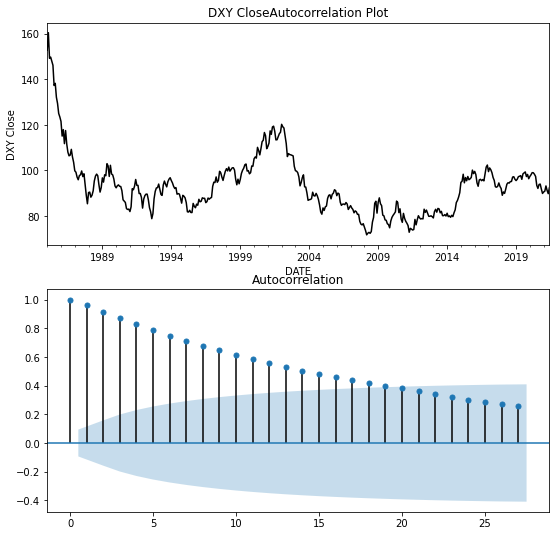

ADF TEST:Vix High
ADF Statistic: -4.798326
p-value: 0.000055


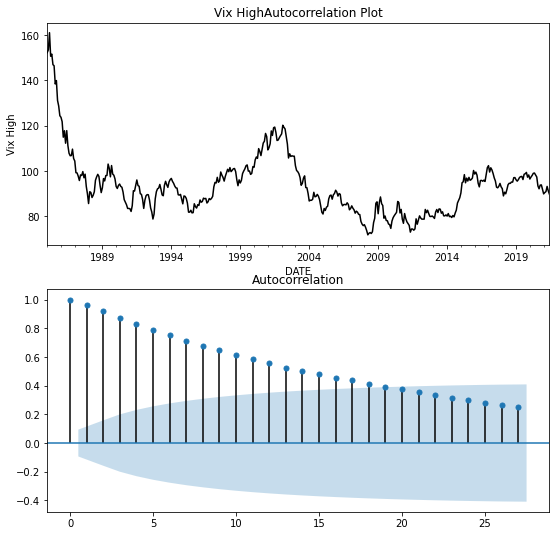

ADF TEST:Vix Low
ADF Statistic: -5.895472
p-value: 0.000000


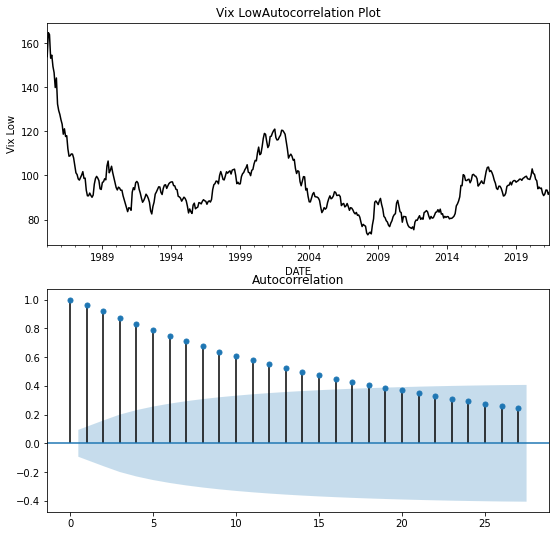

ADF TEST:PMI
ADF Statistic: -7.460660
p-value: 0.000000


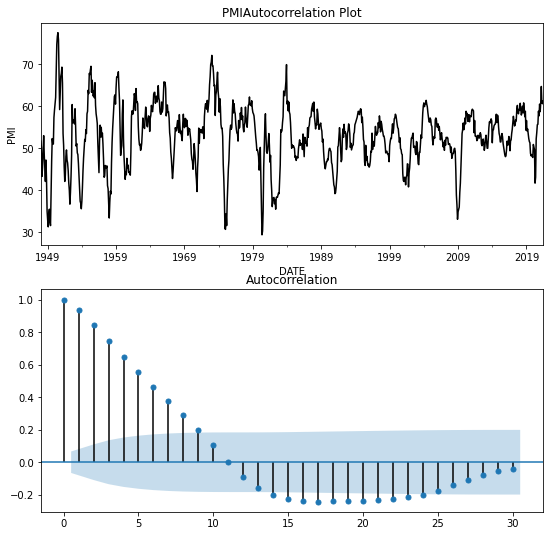

ADF TEST:TwoTenMonthlyVariance
ADF Statistic: -5.861827
p-value: 0.000000


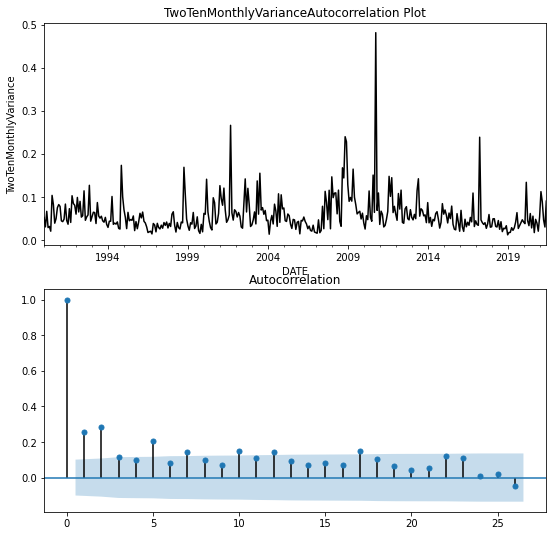

ADF TEST:CpiAnnualizedPct
ADF Statistic: -4.463305
p-value: 0.000229


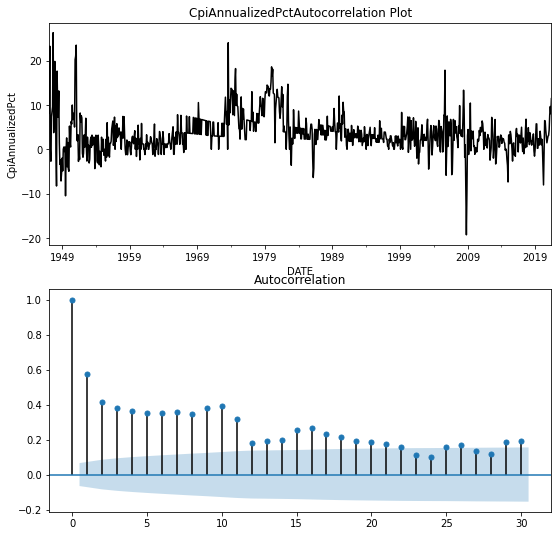

ADF TEST:GdpAnnualizedPct
ADF Statistic: -4.930911
p-value: 0.000030


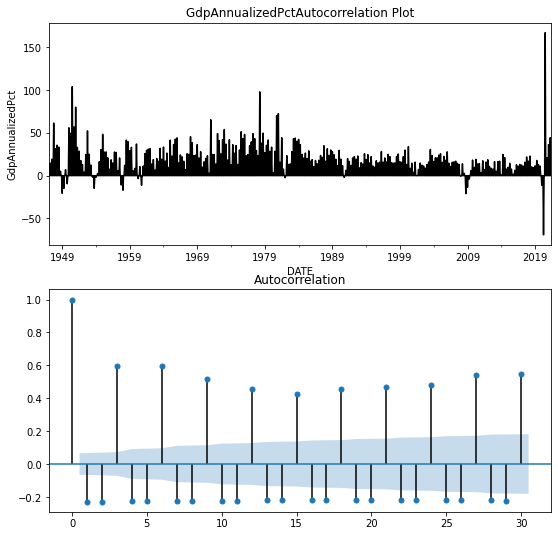

ADF TEST:BopPct
ADF Statistic: -20.627161
p-value: 0.000000


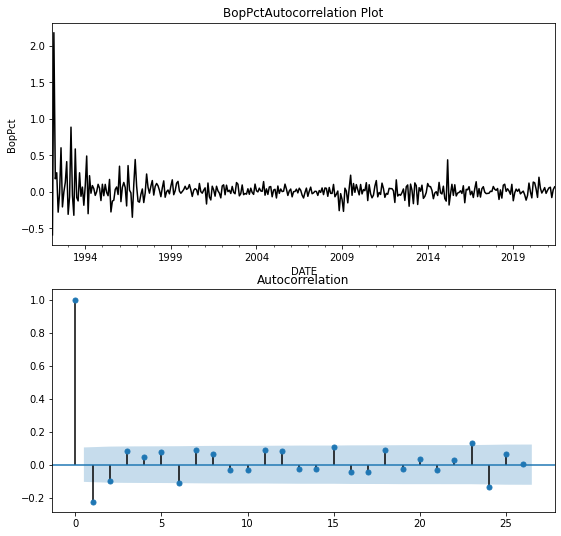

ADF TEST:InventoriesPct
ADF Statistic: -4.955661
p-value: 0.000027


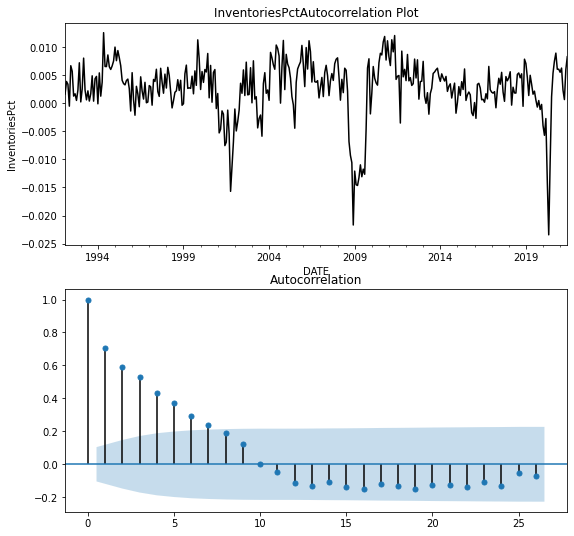

ADF TEST:WtiPct
ADF Statistic: -2.451469
p-value: 0.127733
This Series is not stable


In [156]:
for column in list(dfmain.columns):
   #looping through all the columns in the df
   ADFtest(dfmain, column)

# WTI is not stationary remove
dfmain.drop(columns='WtiPct', inplace=True)


In [ ]:
# dataframe to use for correlation matrix


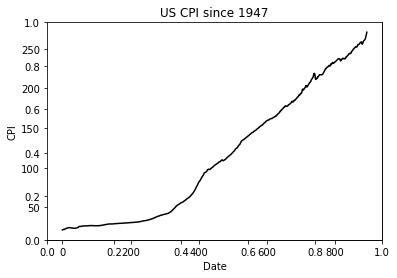

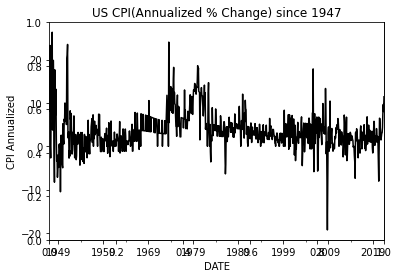

590
            Initial Claims (Seasonally Adjusted)  ...  WtiPct
DATE                                              ...        
1947-01-01                                   NaN  ...     NaN
1947-02-01                                   NaN  ...     NaN
1947-03-01                                   NaN  ...     NaN
1947-04-01                                   NaN  ...     NaN
1947-05-01                                   NaN  ...     NaN
...                                          ...  ...     ...
1995-10-01                              371500.0  ...   17.43
1995-11-01                              377000.0  ...   17.99
1995-12-01                              365000.0  ...   19.03
1996-01-01                              374000.0  ...   18.86
1996-02-01                              377250.0  ...   19.09

[590 rows x 11 columns]


In [166]:

# plot cpi and annualized rate much more stablizied on the second one

fig, axis = plt.subplots()
axis = fig.add_subplot(1,1,1)
axis.set_xlabel("Date")
axis.set_ylabel("CPI")
axis.set_title("US CPI since 1947")

df1['CPIAUCSL'].plot(ax= axis, style='k-')

fig, axis = plt.subplots()
axis = fig.add_subplot(1,1,1)
axis.set_xlabel("Date")
axis.set_ylabel("CPI Annualized")
axis.set_title("US CPI(Annualized % Change) since 1947")


dfmain['CpiAnnualizedPct'].plot(ax= axis, style='k-')
plt.show()



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# indexed date
cpiModelDf = df1.dropna()
cpiModelDf.head()

# ARIMA Model

for pindex in range(3):
    for qindex in range(3):
      p = pindex + 1 
      q = qindex + 1
      CPI_arima_model = ARIMA(cpiModelDf['cpiAnnualizedPct'], order = (p,1,q)).fit()
      print('AR:', p , 'MA:', q, 'AIC:', CPI_arima_model.aic)

CPI_arima_model_selected = ARIMA(cpiModelDf['cpiAnnualizedPct'], order = (2,1,2)).fit()
# fitted model parameters
print("Fitted model")
print(CPI_arima_model_selected.params)
print(CPI_arima_model_selected.summary())

AR: 1 MA: 1 AIC: 4721.640584587954
AR: 1 MA: 2 AIC: 4722.64868430844
AR: 1 MA: 3 AIC: 4723.701490075733
AR: 2 MA: 1 AIC: 4722.694419865345
AR: 2 MA: 2 AIC: 4721.359985096982
AR: 2 MA: 3 AIC: 4723.297890603646
AR: 3 MA: 1 AIC: 4724.657685184024
AR: 3 MA: 2 AIC: 4718.696064215924
AR: 3 MA: 3 AIC: 4719.121945970353
Fitted model
const                      -0.002871
ar.L1.D.cpiAnnualizedPct   -0.618466
ar.L2.D.cpiAnnualizedPct    0.264439
ma.L1.D.cpiAnnualizedPct    0.056919
ma.L2.D.cpiAnnualizedPct   -0.830922
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:     D.cpiAnnualizedPct   No. Observations:                  892
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2354.680
Method:                       css-mle   S.D. of innovations              3.388
Date:                Thu, 05 Aug 2021   AIC                           4721.360
Time:                        00:00:58   BIC                           4750.121

In [ ]:
# model prediction
	
start_index = '1990-12-25'
end_index = '1990-12-25'
forecast = model_fit.predict(start=start_index, end=end_index)